## Setup

In [1]:
here::here()

[1] "/home/fmsb/eebg24-networks-project"

In [2]:
library(pacman)
p_load("DESeq2", "pheatmap", "EnhancedVolcano", "biomaRt", "GEOquery", "dplyr", "GENIE3", install = FALSE)

## Loading datasets

Reference: https://bioconductor.org/packages/release/bioc/vignettes/GEOquery/inst/doc/GEOquery.html#series  

Can be a bit tedious, yet it is a useful package to download metadata. Will require adjustments to your datasets. Worst case - you can create it manually. Don't do such a thing, however. Please.  
As for the count matrix, just go to the assession mage, scroll down -> it's there, the series matrix. Download it, drug'n'drop to the 01_data folder.

In [3]:
gds <- getGEO("GSE89408", GSEMatrix=TRUE)

Found 1 file(s)

GSE89408_series_matrix.txt.gz



In [9]:
meta <- pData(phenoData(gds[[1]]))

In [10]:
counts <- read.delim(here::here("01_data", "GSE89408_count_matrix.txt.gz"), row.names = 1) %>% floor()

In [11]:
meta$title <- names(counts)
meta <- meta %>% filter(stringr::str_detect(title, "normal|RA")) %>% select(title, geo_accession, 'age:ch1', 'disease:ch1', 'Sex:ch1')

In [12]:
counts <- counts[, meta$title]

In [13]:
meta <- meta %>% rename(age = 'age:ch1', disease = 'disease:ch1', sex = 'Sex:ch1')

In [14]:
meta <- meta %>% tibble::rownames_to_column('assession') %>% tibble::column_to_rownames('title')

In [15]:
meta <- meta %>% mutate(etiology = case_when(
    disease == "Normal" ~ "Healthy",
    .default = "RA"))

## DESeq2

Reference: https://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html  
  
Explore your dataset's metadata. Can you put the design as "all healthy vs all diseased"? If yes, do it, and follow my suggestion with the Wald test. If doesn't make sense with the second dataset's design, or if no DE genes (e.g., your diseased groups are too heterogeneous) -> proceed with LRT test (see the reference).  

Suggested thresholds for significance for our study: padj < 0.05, absolute log2FC > 2.

In [16]:
dds_object <- DESeqDataSetFromMatrix(countData = counts, colData = meta,
  design = ~etiology)
dds_object <- DESeq(dds_object, test="Wald")

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1753 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [12]:
res <- results(dds_object)

In [13]:
res_sig <- res %>% as.data.frame %>% filter(padj < 0.05, abs(log2FoldChange) > 2) %>% arrange(desc(log2FoldChange))

In [14]:
write.csv(res_sig, here::here("03_outputs", "GSE89408_differential_expresssion.csv"))

## Genes co-expression (correlation)

In [15]:
counts_normalized <- vst(counts %>% as.matrix())

converting counts to integer mode



In [16]:
counts_normalized <- counts_normalized %>% as.data.frame() %>% filter(rownames(.) %in% rownames(res_sig))

In [17]:
cor_matrix <- cor(counts_normalized %>% t(), method = "pearson")

In [18]:
diag(cor_matrix) <- 0

In [64]:
write.csv(filtered_cor_matrix, here::here("03_outputs", "GSE89408_correlation_matrix.csv"))

## Transcriptional factors inferrence with GENIE3

Refer to: https://bioconductor.org/packages/release/bioc/vignettes/GENIE3/inst/doc/GENIE3.html

In [20]:
tfs <- read.delim(here::here("01_data", "TF_names_v_1.01.txt"), col.names = 0)

In [21]:
tfs <- tfs %>% filter(X0 %in% rownames(counts_normalized))

In [26]:
# this block can run up to 10-30 mins. Prepare some tea.
set.seed(42)
weightMat <- GENIE3(counts_normalized %>% as.matrix(), regulators = tfs$X0, nCores=4)

In [68]:
abs_cor_w <- abs(weightMat)
threshold_w <- quantile(abs_cor_w, probs = 0.75, na.rm = TRUE)
filtered_w_matrix <- ifelse(abs_cor_w >= threshold_w, weightMat, 0)
filtered_w_matrix

,7SK:ENSG00000260682,A1CF,A4GALT,AADAC,AADACL2,AATK,AB209061,ABCA12,ABCA13,ABCA17P,⋯,ZNF784,ZNF80,ZNF816-ZNF321P,ZNF837,ZNF865,ZSCAN1,ZSCAN10,ZSCAN18,ZSWIM2,ZYG11A
AHDC1,0.000000000,0.000000000,0.026227641,0.000000000,0.000000000,0.000000000,0.030272894,0.000000000,0.000000000,0.017220102,⋯,0.000000000,0.000000000,0.015126057,0.013943321,0.02346250,0.005385302,0.000000000,0.02186543,0.006311458,0.000000000
AHRR,0.000000000,0.000000000,0.000000000,0.007404342,0.008917677,0.000000000,0.000000000,0.006734824,0.000000000,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.00000000,0.000000000,0.000000000,0.00000000,0.000000000,0.000000000
AIRE,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.012647463,0.000000000,0.000000000,0.000000000,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.00000000,0.010675166,0.007245753,0.00000000,0.000000000,0.000000000
ALX4,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.007689150,⋯,0.000000000,0.000000000,0.014453616,0.000000000,0.00000000,0.016172993,0.010718491,0.00000000,0.006143355,0.000000000
ARID3A,0.000000000,0.010567425,0.000000000,0.010807527,0.011917595,0.000000000,0.000000000,0.009662147,0.000000000,0.007320236,⋯,0.005208062,0.000000000,0.000000000,0.000000000,0.00000000,0.032082268,0.007565315,0.00000000,0.000000000,0.000000000
ARID3C,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.005457056,0.000000000,0.000000000,0.000000000,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.00000000,0.000000000,0.000000000,0.00000000,0.000000000,0.000000000
ARNTL,0.005741040,0.000000000,0.000000000,0.007812097,0.011556724,0.000000000,0.000000000,0.007263567,0.009448402,0.000000000,⋯,0.000000000,0.011199091,0.000000000,0.000000000,0.00000000,0.000000000,0.000000000,0.00000000,0.014763234,0.005658339
ASCL5,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.00000000,0.016431573,0.019669049,0.00000000,0.000000000,0.000000000
ATOH8,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.008726222,⋯,0.008566879,0.000000000,0.000000000,0.000000000,0.00000000,0.000000000,0.000000000,0.00000000,0.024694844,0.000000000
BARX2,0.000000000,0.007555303,0.000000000,0.025550941,0.031952777,0.000000000,0.000000000,0.023887072,0.005593756,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.00000000,0.000000000,0.000000000,0.00000000,0.000000000,0.000000000


In [28]:
write.csv(weightMat, here::here("03_outputs", "GSE89408_tfs_matrix.csv"))

In [71]:
write.csv(weightMat, here::here("03_outputs", "GSE89408_tfs_matrix_filtered.csv"))

Warning message:
“Arguments must be unnamed”
Warning message in file(file, ifelse(append, "a", "w")):
“cannot open file '/home/fmsb/eebg24-networks-project/03_outputs/GSE89408_tfs_matrix_filtered.csv/FALSE': Not a directory”


ERROR: Error in file(file, ifelse(append, "a", "w")): cannot open the connection


## playground

In [36]:
df <- read.csv(here::here("03_outputs", "protein_drug_interactions.csv"))

Warning message:
“Removed 4 rows containing non-finite outside the scale range (`stat_density()`).”


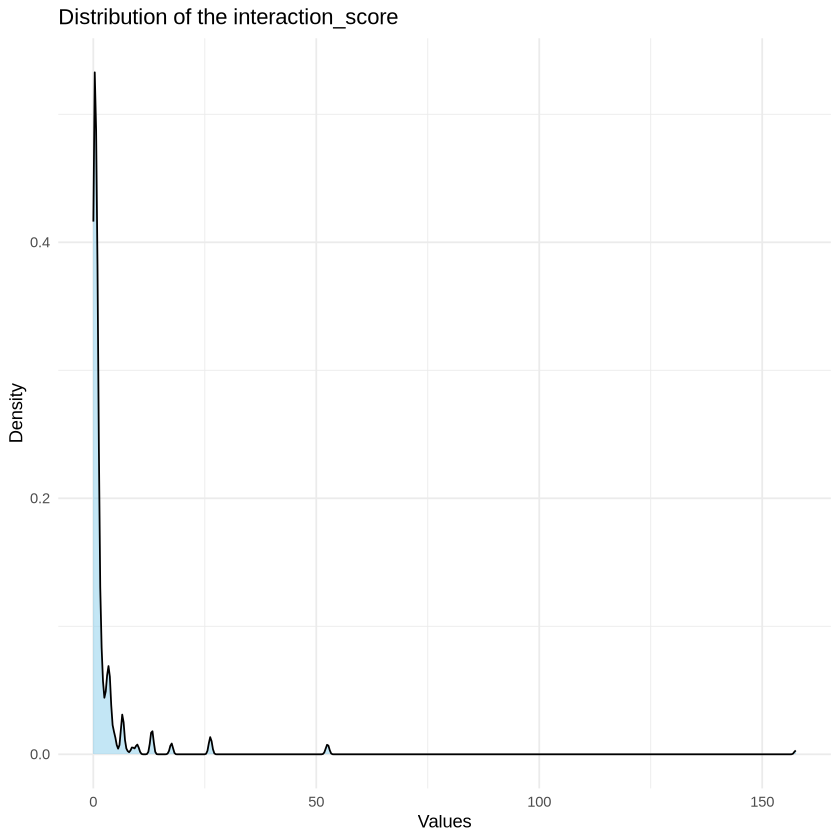

In [49]:
ggplot(df, aes(x = interaction_score)) +
  geom_density(fill = "skyblue", alpha = 0.5) +
  labs(title = "Distribution of the interaction_score",
       x = "Values",
       y = "Density") +
  theme_minimal()


In [53]:
Q3 <- quantile(df$interaction_score, 0.75, na.rm = TRUE)
top_25_percent_df <- df %>% filter(interaction_score >= Q3)

In [54]:
top_25_percent_df

gene_name,drug_name,interaction_score,type_source,type_target
<chr>,<chr>,<dbl>,<chr>,<chr>
TCN1,COBALAMIN,157.523014,protein,drug
HOXC5,BI-3231,52.507671,protein,drug
SDC1,INDATUXIMAB RAVTANSINE,52.507671,protein,drug
SDC1,INDATUXIMAB RAVTANSINE,52.507671,protein,drug
AOC3,TIMOLUMAB,26.253836,protein,drug
S100A9,PAQUINIMOD,26.253836,protein,drug
AOC3,TIMOLUMAB,26.253836,protein,drug
S100A9,TASQUINIMOD,26.253836,protein,drug
CHI3L1,COMPOUND 16 [PMID: 19097778],26.253836,protein,drug


In [55]:
write.csv(top_25_percent_df, here::here("03_outputs", "protein_drug_interactions_filtered.csv"))